In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import joblib

# Load the dataset
# Replace 'file_path.csv' with your dataset path
df = pd.read_csv("fraudTrain.csv")

# Preview the dataset
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
# Problem statement: Identify fraudulent transactions based on available features.

# Target variable
target = 'is_fraud'

# Features (drop irrelevant columns)
features = ['amt', 'category', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']

# Drop rows where the target variable 'is_fraud' has NaN values
df = df.dropna(subset=[target])

# Check for NaN values in the features and drop those rows
df = df.dropna(subset=features)

# Check class imbalance
print(df[target].value_counts())

# If needed, you can also print out the ratio of the classes
print(f"Class imbalance ratio: {df[target].value_counts(normalize=True)}")


is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Class imbalance ratio: is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


In [7]:
# Split the dataset into 80% training and 20% testing
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 1037340
Testing set size: 259335


In [8]:
# Preprocessing: Handle categorical and numerical features
numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']
categorical_features = ['category']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing to training data only
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Resampled training set size: {X_train_resampled.shape[0]}")


Resampled training set size: 2062670


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


# Logistic Regression

In [10]:
# Logistic Regression
logistic_regression = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train the model
logistic_regression.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_lr = logistic_regression.predict(X_test_preprocessed)
y_proba_lr = logistic_regression.predict_proba(X_test_preprocessed)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

# Print results
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Check the labels dynamically (in case they're different)
positive_class = [key for key in report_lr.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']][0]

results_lr = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_lr,
    'ROC-AUC': roc_auc_lr,
    'Precision': report_lr[positive_class]['precision'],
    'Recall': report_lr[positive_class]['recall'],
    'F1-Score': report_lr[positive_class]['f1-score']
}



Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    257834
           1       0.04      0.76      0.07      1501

    accuracy                           0.88    259335
   macro avg       0.52      0.82      0.50    259335
weighted avg       0.99      0.88      0.93    259335



# Decision Tree

In [11]:
# Decision Tree
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
decision_tree.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_dt = decision_tree.predict(X_test_preprocessed)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = None  # Decision trees typically don't have a `predict_proba` method unless it's enabled
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Print results
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# Check the labels dynamically (in case they're different)
positive_class_dt = [key for key in report_dt.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']][0]

results_dt = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy_dt,
    'ROC-AUC': roc_auc_dt,
    'Precision': report_dt[positive_class_dt]['precision'],
    'Recall': report_dt[positive_class_dt]['recall'],
    'F1-Score': report_dt[positive_class_dt]['f1-score']
}


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    257834
           1       0.40      0.77      0.53      1501

    accuracy                           0.99    259335
   macro avg       0.70      0.88      0.76    259335
weighted avg       1.00      0.99      0.99    259335



# Random Forest

In [12]:
# Random Forest
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
random_forest.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_rf = random_forest.predict(X_test_preprocessed)
y_proba_rf = random_forest.predict_proba(X_test_preprocessed)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Print results
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Check the labels dynamically (in case they're different)
positive_class_rf = [key for key in report_rf.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']][0]

results_rf = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_rf,
    'ROC-AUC': roc_auc_rf,
    'Precision': report_rf[positive_class_rf]['precision'],
    'Recall': report_rf[positive_class_rf]['recall'],
    'F1-Score': report_rf[positive_class_rf]['f1-score']
}




Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.60      0.82      0.70      1501

    accuracy                           1.00    259335
   macro avg       0.80      0.91      0.85    259335
weighted avg       1.00      1.00      1.00    259335



# Gradient Boosting

In [13]:
# Gradient Boosting
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Train the model
gradient_boosting.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred_gb = gradient_boosting.predict(X_test_preprocessed)
y_proba_gb = gradient_boosting.predict_proba(X_test_preprocessed)[:, 1]

accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)

# Print results
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

# Check the labels dynamically (in case they're different)
positive_class_gb = [key for key in report_gb.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']][0]

results_gb = {
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy_gb,
    'ROC-AUC': roc_auc_gb,
    'Precision': report_gb[positive_class_gb]['precision'],
    'Recall': report_gb[positive_class_gb]['recall'],
    'F1-Score': report_gb[positive_class_gb]['f1-score']
}




Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    257834
           1       0.13      0.92      0.23      1501

    accuracy                           0.96    259335
   macro avg       0.56      0.94      0.60    259335
weighted avg       0.99      0.96      0.98    259335



In [14]:
# Combine all results into a list
results = [results_lr, results_dt, results_rf, results_gb]

# Convert results into a DataFrame for easier comparison (optional)
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy   ROC-AUC  Precision    Recall  F1-Score
0  Logistic Regression  0.884586  0.905845   0.998395  0.885337  0.938473
1        Decision Tree  0.992033       NaN   0.998678  0.993302  0.995983
2        Random Forest  0.995847  0.987962   0.998955  0.996866  0.997909
3    Gradient Boosting  0.963792  0.989012   0.999509  0.964054  0.981462


In [15]:
# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)

# Sort models by F1-Score and Accuracy
best_model = results_df.sort_values(by=['F1-Score', 'Accuracy'], ascending=False).iloc[0]
print("\nModel Performance Comparison:\n", results_df)
print("\nBest Model:\n", best_model)



Model Performance Comparison:
                  Model  Accuracy   ROC-AUC  Precision    Recall  F1-Score
0  Logistic Regression  0.884586  0.905845   0.998395  0.885337  0.938473
1        Decision Tree  0.992033       NaN   0.998678  0.993302  0.995983
2        Random Forest  0.995847  0.987962   0.998955  0.996866  0.997909
3    Gradient Boosting  0.963792  0.989012   0.999509  0.964054  0.981462

Best Model:
 Model        Random Forest
Accuracy          0.995847
ROC-AUC           0.987962
Precision         0.998955
Recall            0.996866
F1-Score          0.997909
Name: 2, dtype: object


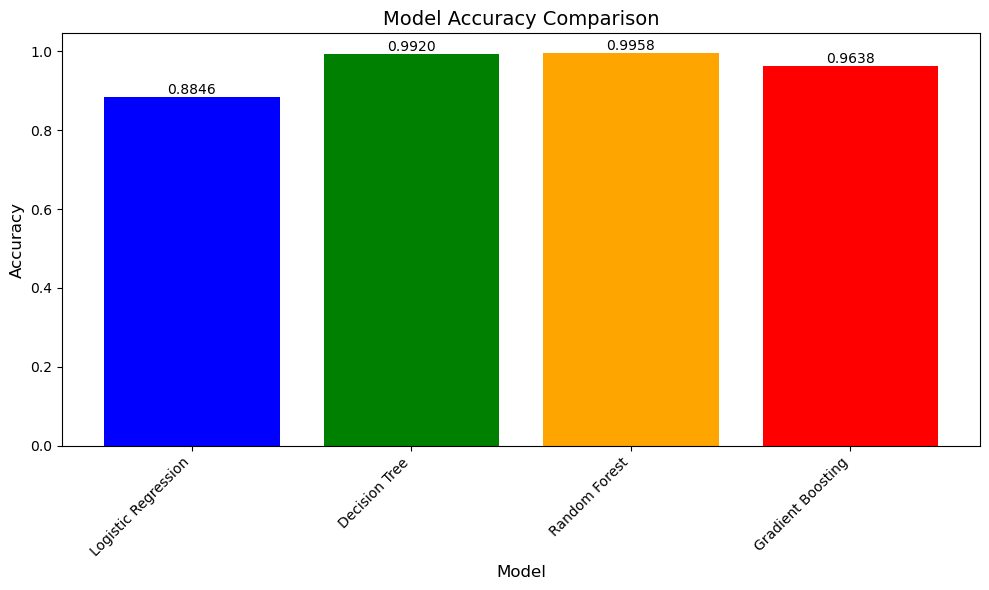

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from Model Performance Comparison
data = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting"],
    "Accuracy": [0.884586, 0.992033, 0.995847, 0.963792],
}

# Convert to DataFrame
results_df = pd.DataFrame(data)

# Plot bar chart for Accuracy
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Accuracy"], color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add accuracy values on top of bars
for index, value in enumerate(results_df["Accuracy"]):
    plt.text(index, value, f"{value:.4f}", ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [17]:
print(X_train.columns)

Index(['amt', 'category', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long',
       'unix_time'],
      dtype='object')


In [18]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define available categorical and numerical features based on the dataset
categorical_features = ['category']  # 'merchant' and 'gender' are missing in this dataset
numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']

# Preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values for numerical data
            ('scaler', StandardScaler())                 # Standardize numerical features
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values for categorical data
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encode categorical features
        ]), categorical_features)
    ]
)

# Example of models dictionary (replace it with actual models)
models = {
    'RandomForestClassifier': RandomForestClassifier(
        n_estimators=200,  # Manually set value
        max_depth=20,      # Manually set value
        min_samples_split=5,  # Manually set value
        random_state=42
    ),
    # Add other model names and instances here if needed
}

# Assuming best_model is a dictionary containing the best model's name
best_model_name = best_model['Model']

# Check and use the model from the models dictionary
if best_model_name == "RandomForestClassifier":
    model = models['RandomForestClassifier']  # Use pre-defined RandomForestClassifier model
else:
    model = models.get(best_model_name, RandomForestClassifier())  # Default to RandomForest if model not found

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Save the trained model
joblib.dump(pipeline, "best_fraud_detection_pipeline.pkl")
print("Pipeline saved successfully!")

# Evaluate the model (optional)
y_pred = pipeline.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))


Pipeline saved successfully!
F1 Score: 0.7330115113256591


In [19]:
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named `df` and the target column is 'is_fraud'
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print the F1 score
print("F1 Score:", f1_score(y_test, y_pred))


F1 Score: 0.9547435467650017


In [21]:
# Load the saved pipeline
loaded_pipeline = joblib.load("best_fraud_detection_pipeline.pkl")

# Use the loaded pipeline to make predictions
y_pred_loaded = loaded_pipeline.predict(X_test)

# Optionally, evaluate the loaded model
print("F1 Score (Loaded Model):", f1_score(y_test, y_pred_loaded))


F1 Score (Loaded Model): 0.9547435467650017


In [25]:
# Save the best pipeline
joblib.dump(best_model_name, 'best_fraud_detection_model.pkl')
print("\nFinal model saved as 'best_fraud_detection_model.pkl'")



Final model saved as 'best_fraud_detection_model.pkl'


In [26]:
X_train.to_csv('train_X.csv', index=False)


In [27]:
import pandas as pd

# Save 10% of the training dataset as a sample
sample_train = X_test.sample(frac=0.1, random_state=42)

# Save the sample as a CSV file
sample_train.to_csv('sample_test.csv', index=False)

print("Sample dataset saved as 'sample_test.csv'")


Sample dataset saved as 'sample_test.csv'
